In [4]:
import heapq
from typing import Dict, List, Tuple, Optional, Any

class NavigationSystem:
    def __init__(self):
        # Graph representation of road network
        self.road_network: Dict[int, List[Tuple[int, float]]] = {}

        # Intersection-specific costs (time to pass through an intersection)
        self.intersection_costs: Dict[int, float] = {}

        # Location names for more realistic navigation
        self.location_names: Dict[int, str] = {}

    def add_location(self, node_id: int, name: str, intersection_cost: float = 0.0):
        """
        Add a named location to the navigation system with an intersection cost

        Args:
        - node_id: Unique identifier for the location/intersection
        - name: Name of the location
        - intersection_cost: Time cost for passing through this intersection (in minutes)
        """
        self.location_names[node_id] = name
        self.intersection_costs[node_id] = intersection_cost

    def add_road(self, start: int, end: int, distance: float):
        """
        Add a road between two locations

        Args:
        - start: Starting location ID
        - end: Ending location ID
        - distance: Road length in kilometers
        """
        # Add to road network (bidirectional)
        if start not in self.road_network:
            self.road_network[start] = []
        if end not in self.road_network:
            self.road_network[end] = []

        self.road_network[start].append((end, distance))
        self.road_network[end].append((start, distance))

    def calculate_route_cost(self, start_node: int, end_node: int) -> Dict[str, Any]:
        """
        Calculate the optimal route using Dijkstra's algorithm

        Considers:
        - Road distance
        - Intersection crossing costs
        """
        # Time tracking for each node
        times = {node: float('inf') for node in self.road_network}
        times[start_node] = 0

        # Track previous nodes for path reconstruction
        previous = {node: None for node in self.road_network}

        # Priority queue for route finding
        pq = [(0, start_node)]

        while pq:
            current_time, current_node = heapq.heappop(pq)

            # Destination reached
            if current_node == end_node:
                break

            # Skip if a longer path is found
            if current_time > times[current_node]:
                continue

            # Explore neighboring routes
            for neighbor, road_distance in self.road_network[current_node]:
                # Calculate total route time
                # Add intersection cost for the neighbor
                intersection_cost = self.intersection_costs.get(neighbor, 0.0)

                # Convert distance to time (assuming 30 km/h average speed)
                road_time = road_distance / 30

                # Total time includes road travel time and intersection crossing time
                route_time = current_time + road_time + intersection_cost/60  # Convert intersection cost to hours

                # Update if better route found
                if route_time < times[neighbor]:
                    times[neighbor] = route_time
                    previous[neighbor] = current_node
                    heapq.heappush(pq, (route_time, neighbor))

        # Reconstruct path
        path = self._reconstruct_path(previous, start_node, end_node)

        # Calculate total travel details
        total_distance = sum(
            self._get_road_distance(path[i], path[i+1])
            for i in range(len(path)-1)
        )

        # Calculate total intersection costs for the path
        total_intersection_cost = sum(
            self.intersection_costs.get(node, 0.0)
            for node in path
        )

        # Use the calculated time directly from Dijkstra's algorithm
        estimated_time = times[end_node]

        return {
            'path': path,
            'total_distance': total_distance,
            'total_intersection_cost': total_intersection_cost,
            'estimated_time': estimated_time,
            'path_details': self._get_path_details(path)
        }

    def _reconstruct_path(self, previous: Dict[int, Optional[int]],
                           start: int, end: int) -> List[int]:
        """Reconstruct the optimal path"""
        path = []
        current = end
        while current is not None:
            path.append(current)
            current = previous[current]
        return list(reversed(path))

    def _get_road_distance(self, start: int, end: int) -> float:
        """Get road distance between two nodes"""
        for neighbor, distance in self.road_network[start]:
            if neighbor == end:
                return distance
        return float('inf')

    def _get_path_details(self, path: List[int]) -> List[Dict[str, Any]]:
        """Generate detailed route information"""
        details = []
        for i in range(len(path) - 1):
            start, end = path[i], path[i+1]

            details.append({
                'from': self.location_names.get(start, f'Location {start}'),
                'to': self.location_names.get(end, f'Location {end}'),
                'distance': self._get_road_distance(start, end),
                'intersection_cost': self.intersection_costs.get(end, 0.0)
            })
        return details

def main():
    # Create navigation system
    nav = NavigationSystem()

    # Add locations with names and intersection costs
    locations = {
        0: ("City Center", 2.0),    # 2 minutes to cross intersection
        1: ("North District", 1.5),  # 1.5 minutes to cross intersection
        2: ("Business Park", 1.0),   # 1 minute to cross intersection
        3: ("Suburban Area", 0.5),   # 0.5 minutes to cross intersection
        4: ("Industrial Zone", 3.0),  # 3 minutes to cross intersection
        5: ("University Campus", 2.5),# 2.5 minutes to cross intersection
        6: ("Waterfront District", 1.0),
        7: ("Tech Hub", 1.5),
        8: ("Residential Complex", 0.5),
        9: ("Airport Vicinity", 2.0)
    }
    for node, (name, intersection_cost) in locations.items():
        nav.add_location(node, name, intersection_cost)

    # Add roads with distances
    road_conditions = [
        # Start, End, Distance
        (0, 1, 15),
        (0, 2, 22),
        (0, 6, 18),
        (1, 2, 10),
        (1, 3, 18),
        (1, 7, 25),
        (2, 3, 25),
        (2, 4, 31),
        (2, 7, 20),
        (3, 4, 12),
        (3, 5, 20),
        (3, 8, 15),
        (4, 5, 15),
        (4, 9, 22),
        (5, 6, 18),
        (6, 7, 16),
        (7, 8, 14),
        (8, 9, 21)
    ]

    # Add roads to navigation system
    for start, end, distance in road_conditions:
        nav.add_road(start, end, distance)

    # Interactive route planning
    while True:
        # Show all available locations
        print("\nAvailable Locations:")
        for node, (name, intersection_cost) in locations.items():
            print(f"{node}: {name} (Intersection Cost: {intersection_cost} minutes)")

        try:
            # Get start and destination
            start_input = input("\nEnter start location (or 'q' to quit): ")
            if start_input.lower() == 'q':
                break

            start = int(start_input)
            dest = int(input("Enter destination location: "))

            # Calculate and display route
            route = nav.calculate_route_cost(start, dest)

            # Print route details
            print("\n--- Navigation Result ---")
            print(f"Route from {locations[start][0]} to {locations[dest][0]}")
            print(f"Total Distance: {route['total_distance']:.2f} km")
            print(f"Total Intersection Cost: {route['total_intersection_cost']:.2f} minutes")
            print(f"Estimated Travel Time: {route['estimated_time']:.2f} hours")

            print("\nRoute Path:")
            path_str = " -> ".join(locations[node][0] for node in route['path'])
            print(path_str)

            print("\nDetailed Route Information:")
            for detail in route['path_details']:
                print(f"- From {detail['from']} to {detail['to']}:")
                print(f"  Distance: {detail['distance']:.2f} km")
                print(f"  Intersection Cost: {detail['intersection_cost']:.2f} minutes")
                print()

        except (ValueError, KeyError):
            print("Invalid input. Please enter valid location numbers.")

if __name__ == "__main__":
    main()


Available Locations:
0: City Center (Intersection Cost: 2.0 minutes)
1: North District (Intersection Cost: 1.5 minutes)
2: Business Park (Intersection Cost: 1.0 minutes)
3: Suburban Area (Intersection Cost: 0.5 minutes)
4: Industrial Zone (Intersection Cost: 3.0 minutes)
5: University Campus (Intersection Cost: 2.5 minutes)
6: Waterfront District (Intersection Cost: 1.0 minutes)
7: Tech Hub (Intersection Cost: 1.5 minutes)
8: Residential Complex (Intersection Cost: 0.5 minutes)
9: Airport Vicinity (Intersection Cost: 2.0 minutes)

Enter start location (or 'q' to quit): 0
Enter destination location: 8

--- Navigation Result ---
Route from City Center to Residential Complex
Total Distance: 48.00 km
Total Intersection Cost: 4.50 minutes
Estimated Travel Time: 1.64 hours

Route Path:
City Center -> North District -> Suburban Area -> Residential Complex

Detailed Route Information:
- From City Center to North District:
  Distance: 15.00 km
  Intersection Cost: 1.50 minutes

- From North Di

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_road_network(road_network: Dict[int, List[Tuple[int, float]]],
                           location_names: Dict[int, str]):
    """
    Visualizes the road network graph.

    Args:
    - road_network: Dictionary of road connections with distances
    - location_names: Dictionary of location names by node ID
    """
    G = nx.Graph()

    # Add nodes with location names
    for node, name in location_names.items():
        G.add_node(node, label=name)

    # Add edges (roads) with distances as edge weights
    for start, neighbors in road_network.items():
        for end, distance in neighbors:
            G.add_edge(start, end, weight=distance)

    # Draw the graph
    pos = nx.spring_layout(G)  # Layout for nodes positioning
    labels = nx.get_edge_attributes(G, 'weight')  # Get edge labels (distances)
    node_labels = nx.get_node_attributes(G, 'label')  # Get node labels (location names)

    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10, font_weight="bold")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title("Road Network")
    plt.show()



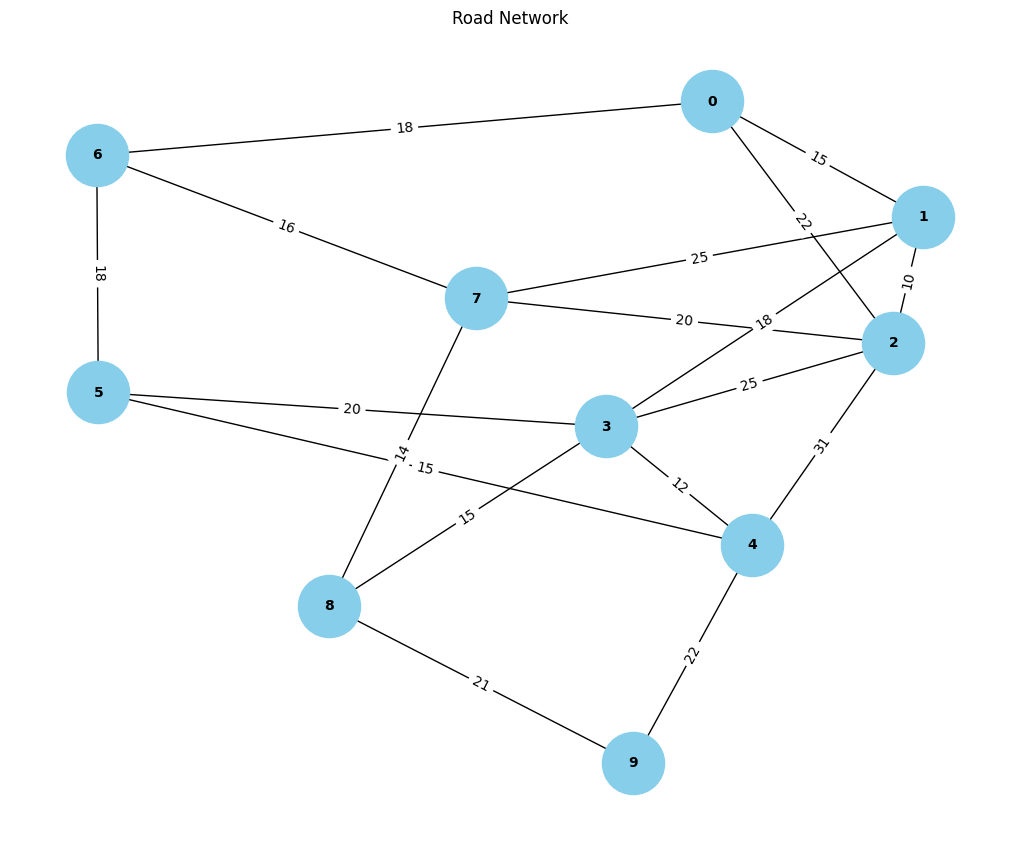

In [3]:
def main():
    nav = NavigationSystem()

    locations = {
        0: ("City Center", 2.0),
        1: ("North District", 1.5),
        2: ("Business Park", 1.0),
        3: ("Suburban Area", 0.5),
        4: ("Industrial Zone", 3.0),
        5: ("University Campus", 2.5),
        6: ("Waterfront District", 1.0),
        7: ("Tech Hub", 1.5),
        8: ("Residential Complex", 0.5),
        9: ("Airport Vicinity", 2.0)
    }
    for node, (name, intersection_cost) in locations.items():
        nav.add_location(node, name, intersection_cost)

    road_conditions = [
        (0, 1, 15),
        (0, 2, 22),
        (0, 6, 18),
        (1, 2, 10),
        (1, 3, 18),
        (1, 7, 25),
        (2, 3, 25),
        (2, 4, 31),
        (2, 7, 20),
        (3, 4, 12),
        (3, 5, 20),
        (3, 8, 15),
        (4, 5, 15),
        (4, 9, 22),
        (5, 6, 18),
        (6, 7, 16),
        (7, 8, 14),
        (8, 9, 21)
    ]
    for start, end, distance in road_conditions:
        nav.add_road(start, end, distance)

    visualize_road_network(nav.road_network, nav.location_names)

if __name__ == "__main__":
    main()
